In [4]:
import pandas as pd
import numpy as np

#Cleans up the Stock information
nyse=pd.read_csv("Data/NYSE.csv")
nasdaq=pd.read_csv("Data/NASDAQ.csv")
amex=pd.read_csv("Data/AMEX.csv")
stocks=nyse.append(nasdaq,ignore_index=True).append(amex,ignore_index=True)
del stocks["Summary Quote"]
i=0
while i<len(stocks["Symbol"]):
    if " (The)" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" (The)")]
    if " Incorporated" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Incorporated")]
    if ", Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc.")]
    if ", Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if ", INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if " Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc.")]
    if " Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if " INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if  " Corporation" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corporation")]
    if " Corp." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp.")]
    if " Corp" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    if " CORP" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    i+=1

#Eliminates Duplicates, inactive tickers, and funds
#For MarketCap n/a; the tickers listed had 1 market value and all other duplicates were n/a; safe to remove
#Additionally, there was the occasional case of no market cap; market cap must have been insignificant or bankrupt
#stocks= stocks[stocks['MarketCap']!="n/a"]
#stocks= stocks[stocks['industry']!="n/a"]
#stocks= stocks[stocks['Sector']!="n/a"]
#stocks= stocks[stocks['IPOyear']!="n/a"]

#Convert MarketCap to Millions of dollars
i=0
while i<len(stocks["MarketCap"]):
    if "B" in str(stocks.iloc[i,3])[-1:]:
        stocks.iloc[i,3]=float(str(stocks.iloc[i,3])[1:-1])*1000
    else:
        stocks.iloc[i,3]=str(stocks.iloc[i,3])[1:-1]
    i+=1

stocks=stocks.reset_index()
del stocks['index']
#delete={1572:'WYIGU',1001:'ANDAU',873:'FNFV',1322:'ELECU',1376:'FCFS',1134:'CLACU',2041:'TRTLU',1706:'MSG'}
# keys=delete.keys()
# keys.sort()
# keys=keys[::-1]
# for key in keys:
#     stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
# stocks=stocks.reset_index()
# del stocks['index']

#Cleans cities data (eliminates counties and combined cities/towns)
cities=pd.read_csv("Data/Living_Index.csv")
cities=cities.rename(columns={"Urban Area":"City"})
values=[]
for x in cities["City"]:
    if "-" in x:
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
values=[]
for x in cities["City"]:
    if "county" in x.lower():
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
new_city_list=[]

for x in cities["City"]:
    y=x[-4:]
    z=x[:-len(y)].replace(",","")+y
    new_city_list.append(z)
cities["City"]=new_city_list

In [26]:
#Put ticker of name instances into a dictionary for all duplicates

#Gives the duplicates in a list called names
names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]
indices=[]
index=[]
dic={}
i=0
while i < len(stocks["Name"]):
    if stocks.loc[i,"Name"] in names:
        if stocks.loc[i,"Name"] in dic.keys():
            dic[stocks.loc[i,"Name"]].append([stocks.loc[i,"Symbol"],stocks.loc[i,"MarketCap"]])
        else:
            dic[stocks.loc[i,"Name"]]=[[stocks.loc[i,"Symbol"],stocks.loc[i,"MarketCap"]]]
    i+=1

#Look up to see if there is a single entry with a market cap for the duplicates; if there is, delete others

#Checks to see if among duplicate entries there is only a single one with market cap
caps=[]
for key in dic.keys():
    l=dic[key]
    single_cap=False
    num_caps=0
    for x in l:
        if x[1]!="/":
            num_caps+=1
        if num_caps==1:
            single_cap=True
        else: 
            single_cap=False
    caps.append([key,single_cap])

#Finds tickers without market cap to delete
delete=[]
for x in caps:
    if x[1]==True:
            #If there is a single market cap value, deletes all others
        for y in dic[x[0]]:
            if y[1]=="/":
                delete.append(y[0])
    if x[1]==False:
            #Checks to see if there are duplicate market cap values; if there are, resorts to largest
        mult=False
        count=0
        for y in dic[x[0]]:
            if y[1]!="/":
                count+=1
            if count>1:
                mult=True
        largest=0
        save_ticker=""
        if mult:
            for y in dic[x[0]]:
                if y[1]!="/":
                    if y[1]>largest:
                        largest=y[1]
                        save_ticker=y[0]
            for z in dic[x[0]]:
                if z[0]!=save_ticker:
                    delete.append(z[0])
            #If there are no market cap values, resorts to shortest ticker name
        else:
            save_ticker=""
            length=10
            for y in dic[x[0]]:
                if len(y[0])<length:
                    save_ticker=y[1]
            for z in dic[x[0]]:
                if z[0]!=save_ticker:
                    delete.append(z[0])

#NOW, time to go through and delete the unneeded rows; 
    #reset the index, get the indices, reverse order the sort,
    #and reset the dataframe on each value; then reset index

indices=[]
i=0
while i<len(stocks):
    if stocks.loc[i,"Symbol"] in delete:
        indices.append(i)
    i+=1
indices.sort()
indices=indices[::-1]
for key in indices:
    stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
stocks=stocks.reset_index()
del stocks['index']

#There is only one case left; where there are duplicate entries; let's delete those now
names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]
delete=[]

for name in names:
    first=True
    i=0
    while i<len(stocks["Name"]):
        if first:
            first=False
        if stocks.loc[i,"Name"]==name:
            delete.append(i)
        i+=1
delete.sort()
delete=delete[::-1]
for key in delete:
    stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
stocks=stocks.reset_index()
del stocks['index']

In [85]:
#Takes in json of webscraped information, puts it into a dataframe, converts Salary information to integers
glass_door=pd.DataFrame(columns=["Salary","Company","Location"])

extension="Data/allcities.json"
json=pd.read_json(extension)
df=pd.DataFrame([json["city"],json["company"],json["meanPay"],json["jobTitle"]]).T
df.columns=["Location","Company","Salary","Job"]
temp=[]


df['Salary'] = df['Salary'].apply(only_numerics)
df=df[pd.notnull(df["Salary"])].reset_index()
del df['index']
df["Salary"]=df['Salary'].astype(np.float)#

glass_door=glass_door.append(df,ignore_index=True)



df.columns=["Location","Company","Salary","Job"]
temp=[]


df['Salary'] = df['Salary'].apply(only_numerics)
df=df[pd.notnull(df["Salary"])].reset_index()
del df['index']
df["Salary"]=df['Salary'].astype(np.float)#

glass_door=glass_door.append(df,ignore_index=True)

df=pd.merge(glass_door,cities,left_on="Location",right_on="City")
df=pd.merge(df,stocks,left_on="Company",right_on="Name",how='inner')
i=0
delete=[]
for x in df["Salary"]:
    if x<10000:
        delete.append(i)
    i+=1
delete.sort()
delete=delete[::-1]
for key in delete:
    df=df.iloc[:key].append(df.iloc[key+1:])
df=df.reset_index()
del df['index']

df['Salary']=df['Salary'].astype(np.int)
df.columns


# todrop=["Software Engineer (Data Scientist)","Data Visualization Scientist",\
#         "Scientist, Statistical and Data Sciences","Associate Data Scientist","Data Scientist Intern - Hourly",\
#         "Data Scientist Intern"]


df["Senior"]=[1 if x else 0 for x in df["Job"]==("Senior Data Scientist")]
df["Mid"]=[1 if x else 0 for x in df["Job"]==("Data Scientist" or "Principal Data Scientist")]
#df["Junior"]=[1 if x else 0 for x in df["Job"]==("Data Scientist I" or "Junior Data Scientist" 
#                                                 or "Data Scientist II")]
df["Large"]=[1 if x else 0 for x in df["MarketCap"]>=500]
df["Small"]=[1 if x else 0 for x in df["MarketCap"]<100]
i=0
while i<len(df):
    if df.loc[i,"MarketCap"] is np.NAN:
        df.loc[i,"MarketCap"]=350
    i+=1
df["MarketCap"]=df["MarketCap"].astype(np.float)

copy=df.copy()
print len(df[df["Senior"]==1])
print len(df[df["Mid"]==1])

92
240


In [73]:
240/92.

2.608695652173913

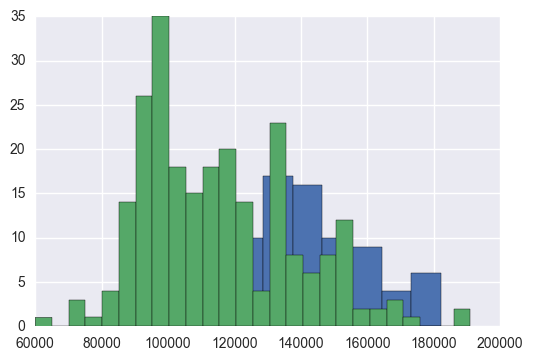

In [76]:
plt.hist(df[df["Senior"]==1]["Salary"],bins=10);
plt.hist((df[df["Mid"]==1]["Salary"]),bins=26);

In [93]:
n=3
increment=(199000-48000.)/float(n)
bins=[48000,85750,148667,199000]
bins=[]
for i in range(n+1):
    bins.append(48000+increment*(i))

replacements=[]
i=0
while i<len(bins)-1:
    replacements.append(str(int(round(bins[i])))+"-"+str(int(round(bins[i+1]))))
    i+=1
    

df=copy.copy()
df["Salary"]=df['Salary'].apply(lambda x: salary_bin(x))
df1=pd.get_dummies(df,columns=["Salary"])

cols=['100% Composite Index','Senior',"Mid","Large"]
# for y in [x for x in df1.columns[20:]]:
#     cols.append(y) 
    
    
X_train,X_test,y_train,y_test=train_test_split(df1[cols],df['Salary'],test_size=.4)#,random_state=69
""" Fit a binary classification predictor."""
logreg = LogisticRegression(solver='lbfgs') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
C_vals = [10**x for x in range (-5,5)]
penalties = ['l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=3)
gs.fit(X_train, y_train)

logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, y_train)
cv_pred = cv_model.predict(X_test)

y_score = cv_model.decision_function(X_test) # Submit these response, the output of model.decision_function

""" Check your performance so far."""

conmat = np.array(confusion_matrix(y_test, cv_pred))
confusion = pd.DataFrame(conmat, index=replacements, columns=replacements)

print(confusion)
print classification_report(y_test,cv_pred)
print cv_model.coef_

               48000-98333  98333-148667  148667-199000
48000-98333              0             0             30
98333-148667             0             0             39
148667-199000            0             0             89
               precision    recall  f1-score   support

148667-199000       0.00      0.00      0.00        30
  48000-98333       0.00      0.00      0.00        39
 98333-148667       0.56      1.00      0.72        89

  avg / total       0.32      0.56      0.41       158

[[ -1.02951861e-02   4.55838023e-05  -2.11933942e-04  -1.66743390e-04]
 [ -8.63202431e-03  -1.15156881e-04   9.52776128e-05  -1.19436710e-05]
 [  2.71291498e-03   3.68842297e-05   2.31250892e-06   1.24653008e-05]]


In [ ]:
""" Fit a binary classification predictor."""
logreg = LogisticRegression(solver='liblinear') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
C_vals = [10**x for x in range (-5,5)]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=3)
gs.fit(X_train, y_train)

logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, y_train)
cv_pred = cv_model.predict(X_test)

y_score = cv_model.decision_function(X_test) # Submit these response, the output of model.decision_function

""" Check your performance so far."""

conmat = np.array(confusion_matrix(y_test, cv_pred))
confusion = pd.DataFrame(conmat, index=replacements,
                            columns=replacements)

print(confusion)
print classification_report(y_test,cv_pred)


In [224]:
roc_auc_score(y_test, y_score)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

ValueError: continuous format is not supported

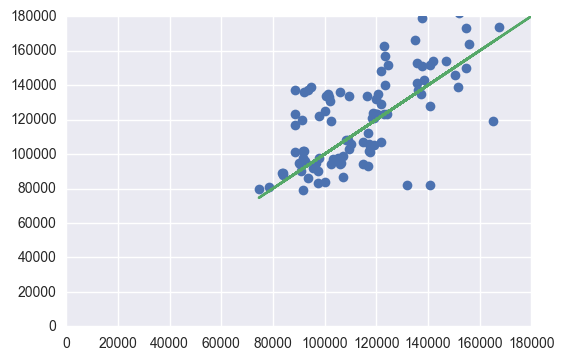

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.963     
Dependent Variable: Salary           AIC:                6816.0834 
Date:               2016-10-17 17:09 BIC:                6830.8448 
No. Observations:   296              Log-Likelihood:     -3404.0   
Df Model:           4                F-statistic:        1914.     
Df Residuals:       292              Prob (F-statistic): 4.45e-208 
R-squared:          0.963            Scale:              5.7854e+08
--------------------------------------------------------------------
        Coef.      Std.Err.     t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
x1      754.2977    27.3167  27.6130  0.0000    700.5350    808.0604
x2        0.0828     0.0085   9.6977  0.0000      0.0660      0.0997
x3    30833.3325  4336.6601   7.1099  0.0000  22298.2588  39368.4061
x4    16945.0181  3513.1597   4.8233  0.0000  10030.6933  23

In [258]:
#Linear Regression
xtr=x_train
xte=x_test
ytr=y_train
yte=y_test

xtr=np.array(xtr).reshape(len(xtr),4)
xte=np.array(xte).reshape(len(xte),4)
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

plt.plot(pred,yte,'o')
plt.plot(pred,pred,'-')
plt.xlim(0,180000)
plt.ylim(0,180000)
plt.show()

print model.summary2()

In [528]:
temp=xtr[:len(xtr)/3]
plt.hist(xte["100% Composite Index"],bins=5)
plt.hist(temp["100% Composite Index"],bins=5)
plt.show()

/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [416]:
df.iloc[730]

Salary                                           138500
Company                                     Capital One
Location                                 Wilmington, DE
City                                     Wilmington, DE
100% Composite Index                              105.2
13 % Grocery Items                                108.1
29 % Housing                                        102
10% Utilities                                     115.4
12 % Transportation                                98.6
4% Health Care                                    108.7
32 % Miscellaneous Goods and Services             105.2
Name: 730, dtype: object

For the logistic regressions, make the discrete value a bin; the smallest bin will be 0. The goal should be to make the bins be organized so that a linear plot can be drawn through them. If the linear plot does not run through them, then there is significant risk of misidentifying a bin. Depending on what the x-axis is (most-likely score), the bins will have to have an equal width along this x-axis (i.e., all bins having a width of x-units on the x-axis).

Contrarily, we want evenly distributed bins in the price aspect.

So, if one were to not do a multinomial logistic regression, one could additionally do a series of logistic regressions. One would check to see if the point goes into bin 0 or 1. If it goes into 1, one would check to see if it goes into bins 1 or 2. If it is in bin 2, one would see if it goes into bins 2 or 3... If it does not go into the higher bin, the regression sequence ends, and the point enters the lower of the two bins.
### Scratch ^; essentially a multinomial logistic regression

In [201]:
df.head()

,Company,Job,Location,Salary,City,100% Composite Index,13 % Grocery Items,29 % Housing,10% Utilities,12 % Transportation,...,32 % Miscellaneous Goods and Services,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Senior,Mid
0,GE,Data Scientist,"Albany, NY",104000,"Albany, NY",108.1,105.0,112.6,101.0,102.8,...,108.6,NaN,NaN,NaN,250.0,NaN,NaN,NaN,0,1
1,State Farm,Data Scientist,"Arlington, TX",105000,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,NaN,NaN,NaN,250.0,NaN,NaN,NaN,0,1
2,Epsilon,Data Scientist,"Arlington, TX",166500,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,NaN,NaN,NaN,250.0,NaN,NaN,NaN,0,1
3,Match,Data Scientist,"Arlington, TX",82500,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,NaN,NaN,NaN,250.0,NaN,NaN,NaN,0,1
4,Hudl,Data Scientist,"Arlington, TX",90000,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,NaN,NaN,NaN,250.0,NaN,NaN,NaN,0,1


In [146]:
#Merge Company Data and Location Data

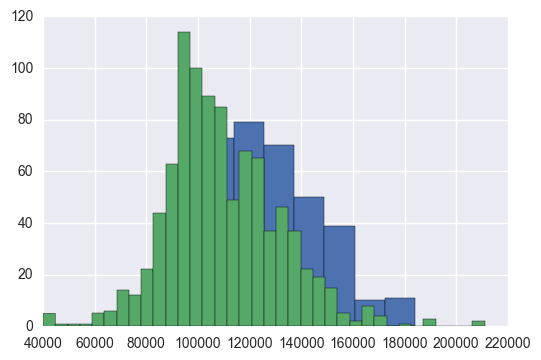

In [113]:
plt.hist(glass_door[glass_door["Job"]=="Senior Data Scientist"]["Salary"],bins=10)
plt.hist(glass_door[glass_door["Job"]=="Data Scientist"]["Salary"],bins=36);

In [5]:
glass_door=glass_door.merge(cities, left_on="Location", right_on="City")

In [ ]:
glass_door=glass_door.merge(cities, left_on="Location", right_on="City")
glass_door["Normalized Salary"]=glass_door["Salary"]/glass_door["100% Composite Index"]

In [9]:
glass_door

,Company,Job,Location,Salary,City_x,100% Composite Index_x,13 % Grocery Items_x,29 % Housing_x,10% Utilities_x,12 % Transportation_x,...,32 % Miscellaneous Goods and Services_y,City,100% Composite Index,13 % Grocery Items,29 % Housing,10% Utilities,12 % Transportation,4% Health Care,32 % Miscellaneous Goods and Services,Normalized Salary
0,GE,Data Scientist,"Albany, NY",104000.0,"Albany, NY",108.1,105.0,112.6,101.0,102.8,...,108.6,"Albany, NY",108.1,105.0,112.6,101.0,102.8,111.7,108.6,962.072155
1,State Farm,Data Scientist,"Arlington, TX",105000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,1057.401813
2,Epsilon,Data Scientist,"Arlington, TX",166000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,1671.701913
3,Match,Data Scientist,"Arlington, TX",82000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,825.780463
4,Hudl,Data Scientist,"Arlington, TX",90000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,906.344411
5,AT&T,Data Scientist,"Arlington, TX",96000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,966.767372
6,IBM,Data Scientist,"Arlington, TX",107000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,1077.542800
7,Capital One,Data Scientist,"Arlington, TX",109000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,1097.683787
8,PwC,Data Scientist,"Arlington, TX",100000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,1007.049345
9,KPMG,Data Scientist,"Arlington, TX",94000.0,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,...,106.4,"Arlington, TX",99.3,94.4,89.4,109.9,98.3,105.4,106.4,946.626385


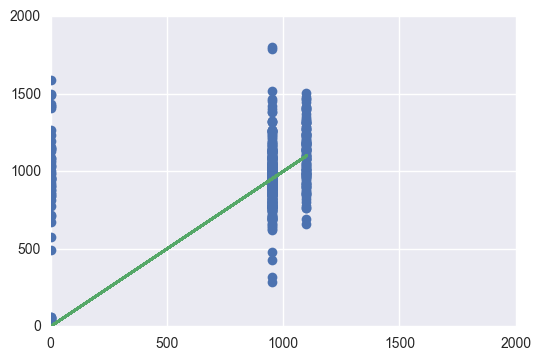

                   Results: Ordinary least squares
Model:              OLS               Adj. R-squared:     0.849     
Dependent Variable: Normalized Salary AIC:                13239.6585
Date:               2016-10-17 22:38  BIC:                13249.2522
No. Observations:   895               Log-Likelihood:     -6617.8   
Df Model:           2                 F-statistic:        2525.     
Df Residuals:       893               Prob (F-statistic): 0.00      
R-squared:          0.850             Scale:              1.5525e+05
----------------------------------------------------------------------
         Coef.     Std.Err.      t      P>|t|      [0.025      0.975] 
----------------------------------------------------------------------
x1     1099.8968    26.2680   41.8721   0.0000   1048.3425   1151.4511
x2      950.2097    16.5473   57.4238   0.0000    917.7335    982.6858
--------------------------------------------------------------------
Omnibus:               286.299       Durbi

In [508]:
df=glass_door.copy()
df["Senior"]=[1 if x else 0 for x in df["Job"]==("Senior Data Scientist" or "Principal Data Scientist")]
df["Mid"]=[1 if x else 0 for x in df["Job"]==("Data Scientist")]
    
#df=df[df["Job"]==("Data Scientist" or "Principal Data Scientist" or "Senior Data Scientist")]
cols=['Senior',"Mid"]
    
    
x_train,x_test,y_train,y_test=train_test_split(df[cols],df['Normalized Salary'],test_size=.35,random_state=70)
""" Fit a binary classification predictor."""
#Linear Regression
xtr=x_train
xte=x_test
ytr=y_train
yte=y_test

xtr=np.array(xtr).reshape(len(xtr),2)
xte=np.array(xte).reshape(len(xte),2)
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

plt.plot(pred,yte,'o')
plt.plot(pred,pred,'-')
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.show()

print model.summary2()

We had discrepancies between the names of the scraped Glass Door data, and the names of the stock information. This led to information not being merged when it should have. So, we manually searched for the pairs of names and input them into a dictionary. This dictionary would be used to rename the mislabeled Glass Door entries.

In [700]:
"""ONLY USED FOR FINDING STOCKS"""

names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]

names=['Price']

#Finds all instances of a company name within stocks["Name"], and prints the instance and its index numer
for name in names:
    i=0
    while i<len(stocks):
        if stocks.loc[i,"Name"]==name:
            print "index: ",i
            print stocks.iloc[i]
            print "\n"
        i+=1

# [x for x in stocks["Name"] if x[0:3]=="Exp"] #-->Additional Search Method; looks for first three letters
# [x for x in stocks["Name"] if "Price".lower() in x.lower()]

In [472]:
change={"GE": "General Electric Company", "IBM":"Microsoft","Capital One":"Capital One Financial",
        "Verizon":"Verizon Communications","Hewlett Packard Enterprise | HPE":'Hewlett Packard Enterprise Company',
       "Hewlett-Packard":'Hewlett Packard Enterprise Company',"Alliance Data":"Alliance Data Systems",
       'Raytheon':'Raytheon Company',"GE":'General Electric Company',"Verizon Wireless":"Verizon Communications",
       "Intel Corporation":"Intel","MaxPoint":"MaxPoint Interactive","General Motors":"General Motors Company",
       "Booz Allen Hamilton":"Booz Allen Hamilton Holding","Nielsen":"Nielsen N.V.","SAP":"SAP SE",
       "General Dynamics Mission Systems":"General Dynamics","Leidos":"Leidos Holdings",
       "Honeywell":"Honeywell International","Akamai":"Akamai Technologies","BNY Mellon":"Bank Of New York Mellon",
       "FIS":"Fidelity National Information Services","J.P. Morgan":'J P Morgan Chase & Co',
       "Walmart":'Wal-Mart Stores',"PayPal":"PayPal Holdings","Adobe":"Adobe Systems",'AOL':"Verizon Communications"}

In [2]:
import pandas as pd
import numpy as np
import requests
import bs4
import pandas as pd
from bs4 import BeautifulSoup
import datetime
import urllib
import statsmodels.api as sm
from sklearn import linear_model
import sklearn
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
% matplotlib inline
lm = linear_model.LinearRegression()
LR=sklearn.linear_model.LogisticRegression
LRCV=sklearn.linear_model.LogisticRegressionCV

/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [500]:
def renaming(x):
    new_name=""
    if x==("Junior Data Scientist"or"Entry Level Data Scientist" or "Data Scientist II" or "Associate Data Scientist"):
        new_name="Junior DS"
    elif x==("Senior Data Scientist" or "Principal Data Scientist"):
        new_name=="Senior DS"
    else:
        new_name="DS"
    return new_name
def name_change(x):
    new_value=""
    if x in change.keys():
        new_value=change[x]
    else:
        new_value=x
    return new_value
def cap(x):
    value=0
    if x is np.NAN:
        value="Unknown"
    elif x>2000:
        value="Hugecap"
    elif x>500:
        value="Largecap"
    elif x>100:
        value="Midcap"
    else:
        value="Smallcap"
    return value
def create_bins(low,high,n):
    increment=(high-low)/float(n)
    bins=[]
    for i in range(n+1):
        bins.append(low+increment*(i))
    replacements=[]
    i=0
    while i<len(bins)-1:
        replacements.append(str(int(round(bins[i])))+"-"+str(int(round(bins[i+1]))))
        i+=1
    return bins,replacements
def salary_bin(bins,replacements,x):
    i=0
    value=0
    while i<len(bins)-1:
        if x<=int(round(bins[i+1])):
            value=replacements[i]
            i=len(bins)
        i+=1
    if value==0:
        value=str(bins[-1])+"+"
    return value
def only_numerics(seq):
    seq = seq.split('-')
    try:
        out = ((int(filter(type(seq[0]).isdigit, seq[0])) + int(filter(type(seq[1]).isdigit, seq[1])))/2)*1000
    except:
        out = int(filter(type(seq[0]).isdigit, seq[0]))
    return out


Uploads the non-Glass Door data.
The stock data is cleaned for:
* Certain terms in the name. Things like 'inc,' or 'corp' are deleted. This helps the matching process.
* The market cap information is converted from strings to millions of dollars.

The city data is cleaned for:

* Cities containing '-'
* Cities containing 'county'
* Removing ',' from city names

In [442]:
#Cleans up the Stock information
nyse=pd.read_csv("Data/NYSE.csv")
nasdaq=pd.read_csv("Data/NASDAQ.csv")
amex=pd.read_csv("Data/AMEX.csv")
stocks=nyse.append(nasdaq,ignore_index=True).append(amex,ignore_index=True)
del stocks["Summary Quote"]
i=0
while i<len(stocks["Symbol"]):
    if " (The)" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" (The)")]
    if " Incorporated" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Incorporated")]
    if ", Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc.")]
    if ", Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if ", INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if " Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc.")]
    if " Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if " INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if  " Corporation" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corporation")]
    if " Corp." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp.")]
    if " Corp" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    if " CORP" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    i+=1

#Convert MarketCap to Millions of dollars
i=0
while i<len(stocks["MarketCap"]):
    if "B" in str(stocks.iloc[i,3])[-1:]:
        stocks.iloc[i,3]=float(str(stocks.iloc[i,3])[1:-1])*1000
    else:
        stocks.iloc[i,3]=str(stocks.iloc[i,3])[1:-1]
    i+=1

stocks=stocks.reset_index()
del stocks['index']

#Cleans cities data (eliminates counties and combined cities/towns)
cities=pd.read_csv("Data/Living_Index.csv")
cities=cities.rename(columns={"Urban Area":"City"})
values=[]
for x in cities["City"]:
    if "-" in x:
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
values=[]
for x in cities["City"]:
    if "county" in x.lower():
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
new_city_list=[]

for x in cities["City"]:
    y=x[-4:]
    z=x[:-len(y)].replace(",","")+y
    new_city_list.append(z)
cities["City"]=new_city_list

We initiate a Glass Door data frame to connect the json to.
We upload the json, which has four columns:
* Location
* Company
* Salary
* Job

We clean the json df for:
* Changing salary ranges to averagees

We save the json df as 'glass_door'.

We clean the glass_door df for:
* Name changes found listed above

We merge the glass_door df with cities. 

We create a new column "Normalized Salary".

In [444]:
glass_door=pd.DataFrame(columns=["Salary","Company","Location"])

extension="Data/allcities.json"
json=pd.read_json(extension)
df=pd.DataFrame([json["city"],json["company"],json["meanPay"],json["jobTitle"]]).T
df.columns=["Location","Company","Salary","Job"]
temp=[]


df['Salary'] = df['Salary'].apply(only_numerics)
df=df[pd.notnull(df["Salary"])].reset_index()
del df['index']
df["Salary"]=df['Salary'].astype(np.float)#

glass_door=glass_door.append(df,ignore_index=True)

glass_door["Company"]=glass_door["Company"].apply(lambda x: name_change(x))

glass_door=glass_door.merge(cities, left_on="Location", right_on="City")
glass_door["Normalized Salary"]=glass_door["Salary"]/glass_door["100% Composite Index"]

We merge the glass_door df with stocks. We only select those Jobs that are Junior Level, Middle Level, or Senior Level. We dont want to end up with internships. We then bin the jobs with their respective bin names (as just mentioned).

For the most recurring private companies, market cap and sectors were updated as they had an impact on prediction ability.

Null values in market cap and sector were changed appropriately.

In [681]:
df=glass_door.copy()
df=df.merge(stocks, how='left',left_on="Company",right_on="Name")
df=df[df["Job"]==("Senior Data Scientist" or "Principal Data Scientist" or "Data Scientist" or "Junior Data Scientist"
                 or "Entry Level Data Scientist" or "Data Scientist II" or "Associate Data Scientist")]


df["Job"]=df["Job"].apply(lambda x: renaming(x))



marketcap_sectors={'KPMG':[24440,"Consulting"],'Razorfish':[np.NaN,"Technology"],
                   'Elevate Credit':[640,"Finance"],'BCG Digital Ventures':[np.NaN,"Finance"]}

df=df.reset_index()
del df["index"]
i=0
while i<len(df):
    if df.loc[i,"Company"] in marketcap_sectors.keys():
        df.loc[i,"MarketCap"]=marketcap_sectors[df.loc[i,"Company"]][0]
        df.loc[i,"Sector"]=marketcap_sectors[df.loc[i,"Company"]][1]
    i+=1

df["Sector"]=["Technology" if pd.isnull(x) else x for x in df["Sector"]]
df["MarketCap"]=df["MarketCap"].apply(lambda x: cap(x))
#df["MarketCapSector"]=df["Sector"]+df["MarketCap"]

In [682]:
df2=pd.get_dummies(df,columns=["Sector","MarketCap","State","Region"])
delete=[u'industry',u'Company', u'Location', u'Salary', u'City',
       u'Symbol', u'Name', u'LastSale', u'IPOyear',u'Normalized Salary',u'100% Composite Index',"Job"] 
#u'13 % Grocery Items', u'29 % Housing',
#      u'10% Utilities', u'12 % Transportation', u'4% Health Care',
#       u'32 % Miscellaneous Goods and Services',
for x in delete:
    del df2[x]

normalizer=pd.DataFrame(df["100% Composite Index"].copy(),columns=["100% Composite Index"])
df2=df2.reset_index()
del df2['index']
normalizer=normalizer.reset_index()
del normalizer['index']
i=0
cols=df2.columns
while i<len(df2):
    for x in cols:
        df2.loc[i,x]=df2.loc[i,x]*normalizer.loc[i,"100% Composite Index"]
    i+=1

In [683]:
#ENTER BINS BELOW
bin_NUMBER=3

temp2=pd.DataFrame(df["Salary"].copy(),columns=["Salary"])
bins2,replacements2=create_bins(min(temp2["Salary"]),max(temp2["Salary"]),bin_NUMBER)

temp=pd.DataFrame(df["Salary"].copy(),columns=["Salary"])
bins,replacements=create_bins(min(temp["Salary"]),max(temp["Salary"]),bin_NUMBER)
temp["Normalized Salary"]=temp["Salary"].apply(lambda x: salary_bin(bins,replacements,x))
#df1=pd.get_dummies(temp,columns=["Normalized Salary"])
df1=temp["Normalized Salary"]

In [684]:
prec=[]
recall=[]
f1score=[]
max_rand=20

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(df2,df1,test_size=.35,stratify=df1,random_state=random)
    logreg = LogisticRegression(solver='lbfgs') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
    C_vals = np.linspace(1,1001,10)
    penalties = ['l2']

    gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=3)
    gs.fit(x_train, y_train)

    logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)

    y_score = cv_model.decision_function(x_test) # Submit these response, the output of model.decision_function

    """ Check your performance so far."""

    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)
    
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))
#    
print "Number of bins:    ", bin_NUMBER
print "Random Iterations: ", max_rand-1
print 
print "Average Precision: ", np.mean(prec)
print "Average Recall:    ", np.mean(recall)
print "Average F1-Score:  ", np.mean(f1score)
print 
print "Variance Precision:", np.var(prec)
print "Variance Recall:   ", np.var(recall)
print "Variance F1-Score: ", np.var(f1score)


#     print(confusion)
#     print classification_report(y_test,cv_pred)
    #print cv_model.coef_

Number of bins:     3
Random Iterations:  19

Average Precision:  0.756315789474
Average Recall:     0.754736842105
Average F1-Score:   0.751052631579

Variance Precision: 0.000675900277008
Variance Recall:    0.00067756232687
Variance F1-Score:  0.000609418282548


## BEST with Junior Jobs and no Job Dummies
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## Best with No Junior Jobs and Job Dummies
* Number of bins:    3
* Average Precision:  0.755789473684
* Average Recall:     0.754210526316
* Average F1-Score:   0.75

## Best with No Junior Jobs and no Job Dummies
* Number of bins:    3
* Average Precision:  0.756315789474
* Average Recall:     0.754736842105
* Average F1-Score:   0.751052631579

## Standard Company Changes:
* Number of bins:    3
* Average Precision: 0.748947368421
* Average Recall:    0.748947368421
* Average F1-Score:  0.744736842105

## With Private Company changes:
* Number of bins:    3
* Average Precision: 0.755789473684
* Average Recall:    0.754210526316
* Average F1-Score:  0.75

## With PC changes and no Job Dummies:
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## Standard Company Changes:
* Number of bins:    3
* Average Precision: 0.748947368421
* Average Recall:    0.748947368421
* Average F1-Score:  0.744736842105

## With Private Company changes:
* Number of bins:    3
* Average Precision: 0.755789473684
* Average Recall:    0.754210526316
* Average F1-Score:  0.75

## With Private Company changes and Sector-MarketCap Bin:
* Number of bins:    3
* Average Precision: 0.753157894737
* Average Recall:    0.752105263158
* Average F1-Score:  0.748421052632

## With PC changes and no State Dummies:
* Number of bins:    3
* Average Precision: 0.723684210526
* Average Recall:    0.726842105263
* Average F1-Score:  0.72

## With PC changes and no Region Dummies:
* Number of bins:    3
* Average Precision: 0.754210526316
* Average Recall:    0.754210526316
* Average F1-Score:  0.748421052632

## With PC changes and no Job Dummies:
* Number of bins:    3
* Average Precision: 0.756315789474
* Average Recall:    0.754736842105
* Average F1-Score:  0.751052631579

## With PC changes, no J D, and no MarketCap Dummies


In [635]:
print classification_report(y_test,cv_pred)[-35:]
prec=classification_report(y_test,cv_pred)[-35:-31]
recall=classification_report(y_test,cv_pred)[-25:-21]
f1score=classification_report(y_test,cv_pred)[-15:-11]

print prec
print recall
print f1score

0.51      0.51      0.51       172

0.51
0.51
0.51


In [564]:
cv_model.classes_

array(['1356-1717', '633-994', '994-1356'], dtype=object)

In [581]:
#plt.hist(df["Salary"],bins=30)
172*len(df[df["Salary"]>145000])/float(len(df["Salary"]))

27.43558282208589

In [510]:
print gs.best_params_['C'], gs.best_params_['penalty']

445.444444444 l2


In [685]:
x_train2,x_test2,y_train2,y_test2=train_test_split(df2,df['Salary'],test_size=.35)

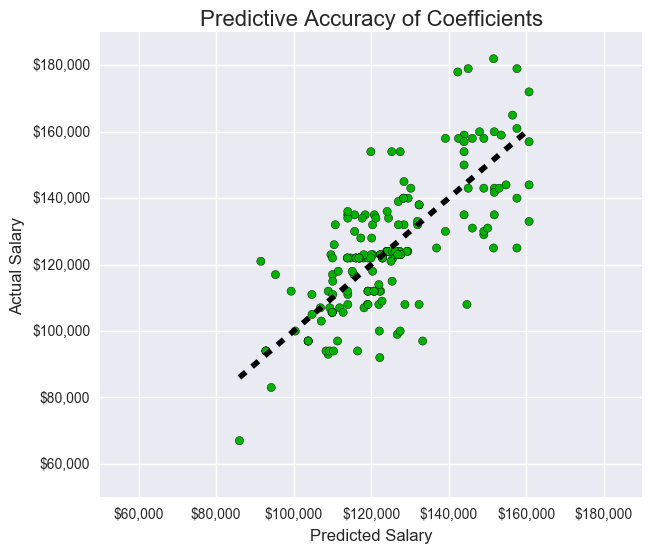

In [873]:
""" Fit a binary classification predictor."""
#Linear Regression
xtr=x_train2
xte=x_test2
ytr=y_train2
yte=y_test2

xtr=np.array(xtr).reshape(len(xtr),len(x_train2.columns))
xte=np.array(xte).reshape(len(xte),len(x_train2.columns))
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

fig,axes=plt.subplots(figsize=(7,6))
plt.scatter(pred,yte,c=(0,.7,0,1),s=[35 for x in range(len(pred))])
temp=pred
temp.sort()
plt.plot(temp,temp,'--',c=(0,0,0,1),linewidth=4)
plt.xlim(50000,190000)
plt.ylim(50000,190000)
plt.xlabel("Predicted Salary",size=12)
plt.ylabel("Actual Salary",size=12)
plt.title("Predictive Accuracy of Coefficients",size=16)
plt.xticks(np.linspace(60000,180000,7),['$60,000','$80,000','$100,000','$120,000','$140,000','$160,000',
                                        '$180,000'])
plt.yticks(np.linspace(60000,180000,7),['$60,000','$80,000','$100,000','$120,000','$140,000','$160,000',
                                        '$180,000'])
plt.show()

#print model.summary2()

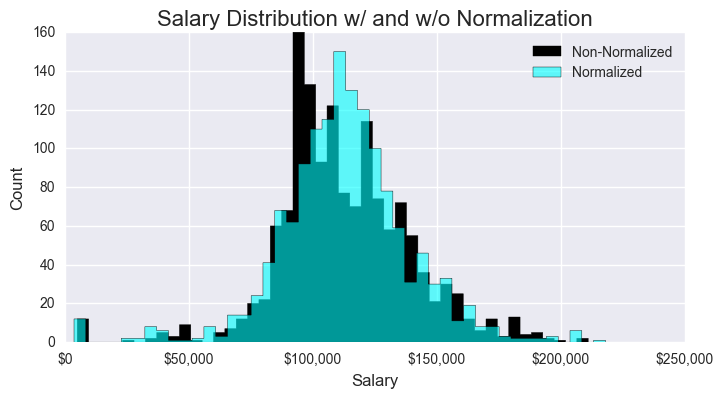

In [822]:
##MAKE THIS PRETTIER; We will present with this

fig,ax=plt.subplots(figsize=(8,4))
average=np.mean(glass_door["100% Composite Index"])
#\plt.hist(glass_door["Salary"]/average,width=50)
plt.hist(glass_door["Salary"],bins=45,color=(0,0,0,1),histtype='stepfilled',label="Non-Normalized")
plt.hist(glass_door["Normalized Salary"]*115,bins=45,color=(0,1,1,.6),histtype='stepfilled',label="Normalized")
plt.xlabel("Salary",size=12)
plt.ylabel("Count",size=12)
plt.title("Salary Distribution w/ and w/o Normalization",size=16)
plt.legend(loc='upper right')
plt.xticks(np.linspace(0,250000,6),['$0',"$50,000","$100,000",'$150,000','$200,000','$250,000'])
plt.show()

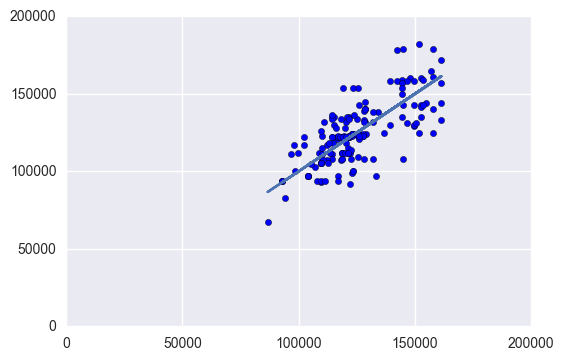

0.537913063917


13 % Grocery Items
4.6375013765

29 % Housing
0.333347151532

10% Utilities
0.83042997926

12 % Transportation
-8.75665722816

4% Health Care
2.05785933563

32 % Miscellaneous Goods and Services
2.23908799143

Sector_Capital Goods
8.85180886134

Sector_Consulting
-137.501726932

Sector_Consumer Durables
167.458201538

Sector_Consumer Services
-18.9426250208

Sector_Energy
-79.0831998932

Sector_Finance
-37.8545289796

Sector_Health Care
92.5677123014

Sector_Miscellaneous
-70.8573656826

Sector_Public Utilities
0.97240676799

Sector_Technology
29.0694542584

Sector_n/a
-61.5905029444

MarketCap_Hugecap
15.091818822

MarketCap_Largecap
-61.9502610339

MarketCap_Unknown
-38.4291534531

State_AL
-157.978221159

State_AR
-254.734037113

State_AZ
-153.734076083

State_CA
83.6590222125

State_CO
-166.393785017

State_CT
10.2642366522

State_DE
-48.279997616

State_FL
-236.393459829

State_GA
-36.9729372618

State_IL
-49.7918669496

State_IN
-5.55708760939

State_KY
220.79864

In [870]:
ridge=Ridge(alpha=10) #Ridge is .28269 at 230
lasso=Lasso(alpha=0.5) #Lasso is 0.289105 at 2.01
lr=LinearRegression() #Linear Regression is .2763265
model=lasso.fit(x_train2,y_train2)
pred=model.predict(x_test2)
plt.scatter(pred,y_test2)
plt.plot(pred,pred)
plt.ylim(0,200000)
plt.xlim(0,200000)
plt.show()
print model.score(x_test2, y_test2)
print "\n"
for x,y in zip(x_test2.columns,model.coef_):
    print x
    print y
    print